In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab_me/DS300/recommenders/

/content/drive/MyDrive/Colab_me/DS300/recommenders


## 0 Global Settings and Import

In [ ]:
# !pip install scrapbook
# !pip install papermill
# !pip install cornac
# !pip install retrying
# !pip install pandera

In [ ]:
# set the environment path to find Recommenders
import sys

import pandas as pd
import numpy as np
import scrapbook as sb
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

#For interactive mode only
%load_ext autoreload
%autoreload 2
%matplotlib inline

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Pandas version: 1.5.3
Tensorflow version: 2.15.0


# 1 Load Data

Here we select the size of the movielens dataset. In this example we consider the 100k ratings datasets, provided by  943 users on 1682 movies. The data are imported in a pandas dataframe including the user ID, the item ID, the ratings and a timestamp denoting when a particular user rated a particular item.  

In [ ]:
import time
import datetime

In [ ]:
# %cd /content/drive/MyDrive/DS300_DoAn/data

In [ ]:
df = pd.read_csv('/content/data_history.csv')
convert_timestamp = lambda x: time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple())

df['timestamp'] = df['Date'].apply(convert_timestamp)

In [ ]:
df = df.rename(columns={'IDuser': "userID", 'IDhotel': "movieID", 'Rating': "rating"})
df = df[['userID','movieID','rating','timestamp']]

data = df[df.userID.map(df.userID.value_counts()) > 4]
data

,userID,movieID,rating,timestamp
8,3827,378,6.0,1.325981e+09
10,5272,182,6.0,1.328573e+09
11,5822,308,6.0,1.328659e+09
14,5754,141,6.7,1.331165e+09
15,5961,334,6.7,1.331856e+09
...,...,...,...,...
18247,5668,103,8.0,1.701907e+09
18255,8139,47,10.0,1.701907e+09
18256,4080,140,8.0,1.701994e+09
18263,5857,571,4.0,1.701994e+09


In [ ]:
# data.rating = round(data.rating)

### 1.2 Split the data using the stratified splitter  

As a second step we generate the user/item affiity matrix and then split the data into train and test set. If you are familiar with training supervised learning model, here you will notice the first difference. In the former case, we cut off a certain proportion of training examples from dataset (e.g. images), here corresponding to users (or items), ending up with two matrices (train and test) having different row dimensions. Here we need to mantain the same matrix size for the train and test set, but the two will contain different amounts of ratings, see the [deep dive notebook](../02_model/rbm_deep_dive.ipynb) for more details. The affinity matrix reads     

In [ ]:
#to use standard names across the analysis
header = {
        "col_user": "userID",
        "col_item": "movieID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation
am = AffinityMatrix(df = data, **header)

#obtain the sparse matrix
X, _, _ = am.gen_affinity_matrix()

The method also returns informations on the sparsness of the dataset and the size of the user/affinity matrix. The former is given by the ratio between the unrated elements and the total number of matrix elements. This is what makes a recommendation task hard: we try to predict 93% of the missing data with only 7% of information!

We split the matrix using the default ration of 0.75, i.e. 75% of the ratings will constitute the train set.

In [ ]:
Xtr, Xtst = numpy_stratified_split(X, ratio=0.8, seed=42)

In [ ]:
Xtr

array([[7., 0., 7., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 4., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
Xtst

array([[ 0.,  9.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0., 10.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

The splitter returns:

- Xtr: a matrix containing the train set ratings
- Xtst: a matrix containing the test elements

Note that the train/test matrices have exactly the same dimension, but different entries as it can be explicitly verified:

## 2 Train the RBM model

The model has been implemented as a Tensorflow (TF) class. TF does not support probabilistic models natively, so the implementation of the algorithm has a different structure than the one you may be used to see in popular supervised models. The class has been implemented in such a way that the TF session is hidden inside the `fit()` method and no explicit call is needed. The algorithm operates in three different steps:

- Model initialization: This is where we tell TF how to build the computational graph. The main parameters to specify are the number of hidden units, the number of training epochs and the minibatch size. Other parameters can be optionally tweaked for experimentation and to achieve better performance, as explained in the [RBM Deep Dive section](../02_model/rbm_deep_dive.ipynb).

- Model fit: This is where we train the model on the data. The method takes two arguments: the training and test set matrices. Note that the model is trained **only** on the training set, the test set is used to display the generalization accuracy of the trained model, useful to have an idea of how to fix the hyper parameters.

- Model prediction: This is where we generate ratings for the unseen items. Once the model has been trained and we are satisfied with its overall accuracy, we sample new ratings from the learned distribution. In particular, we extract the top_k (e.g. 10) most relevant recommendations according to some predefined score. The prediction is then returned in a dataframe format ready to be analysed and deployed.  

In [ ]:
#First we initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])),
    visible_units=Xtr.shape[1],
    hidden_units=100,
    training_epoch=1,
    minibatch_size=30,
    keep_prob=0.9,
    with_metrics=True
)

Note that the first time the fit method is called it may take longer to return the result. This is due to the fact that TF needs to initialized the GPU session. You will notice that this is not the case when training the algorithm the second or more times.   

Took 1.36 seconds for training.


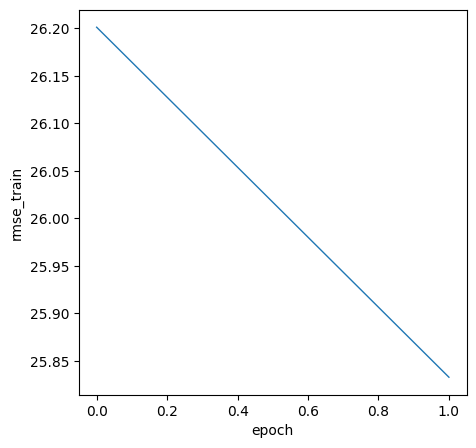

In [ ]:
# Model Fit
with Timer() as train_time:
    model.fit(Xtr)

print("Took {:.2f} seconds for training.".format(train_time.interval))

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

During training, we can optionlly evauate the root mean squared error to have an idea of how the learning is proceeding. We would generally like to see this quantity decreasing as a function of the learning epochs. To visualise this choose `with_metrics = True` in the `RBM()` model function.

Once the model has been trained, we can predict new ratings on the test set.

In [ ]:
# number of top score elements to be recommended
K = 10

# Model prediction on the test set Xtst.
with Timer() as prediction_time:
    top_k =  model.recommend_k_items(Xtst)

print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))

Took 0.88 seconds for prediction.


`top_k` returns the first K elements having the highest recommendation score. Here the recommendation score is evaluated by multiplying the predicted rating by its probability, i.e. the confidence the algorithm has about its output. So if we have two items both with predicted ratings 5, but one with probability 0.5 and the other 0.9, the latter will be considered more relevant. In order to inspect the prediction and use the evaluation metrics in this repository, we convert both top_k and Xtst to pandas dataframe format:

In [ ]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [ ]:
top_k_df

,userID,movieID,prediction
0,70,124,29.262749
1,70,65,28.539267
2,70,264,28.161957
3,70,210,29.496660
4,70,15,30.761869
...,...,...,...
4939,10664,421,30.041374
4940,10664,416,28.849026
4941,10664,96,29.979052
4942,10664,428,29.860415


In [ ]:
test_df

,userID,movieID,rating
0,70,124,9.0
1,70,508,6.0
2,86,465,2.0
3,86,434,10.0
4,100,395,1.0
...,...,...,...
858,10657,286,5.0
859,10657,399,10.0
860,10659,447,5.8
861,10659,246,9.5


## 4 Evaluation metrics

Here we evaluate the performance of the algorithm using the metrics provided in the `PythonRankingEvaluation` class. Note that the following metrics take into account only the first K elements, therefore their value may be different from the one displayed from the `model.fit()` method.

In [ ]:
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="movieID",
                    col_rating="rating", col_prediction="prediction",
                    relevancy_method="top_k", k= K)

    eval_ndcg_10 = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID",
                      col_rating="rating", col_prediction="prediction",
                      relevancy_method="top_k", k= K)

    eval_ndcg_5 = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID",
                      col_rating="rating", col_prediction="prediction",
                      relevancy_method="top_k", k= 5)

    eval_precision_10 = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID",
                               col_rating="rating", col_prediction="prediction",
                               relevancy_method="top_k", k= K)

    eval_precision_5 = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID",
                               col_rating="rating", col_prediction="prediction",
                               relevancy_method="top_k", k= 5)

    eval_recall_10 = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID",
                          col_rating="rating", col_prediction="prediction",
                          relevancy_method="top_k", k= K)

    eval_recall_5 = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID",
                          col_rating="rating", col_prediction="prediction",
                          relevancy_method="top_k", k= 5)


    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP@K": eval_map,
            "nDCG@k": eval_ndcg_10,
            "nDCG@5": eval_ndcg_5,
            "Precision@k": eval_precision_10,
            "Precision@5": eval_precision_5,
            "Recall@k": eval_recall_10,
            "Recall@5": eval_recall_5
        },
        index=[0]
    )

    return df_result

In [ ]:
eval_100k = ranking_metrics(
    data_size="Hotel_dataset",
    data_true=test_df,
    data_pred=top_k_df,
    K=10
)

eval_100k

,Dataset,K,MAP@K,nDCG@k,nDCG@5,Precision@k,Precision@5,Recall@k,Recall@5
0,Hotel_dataset,10,0.231847,0.300705,0.263261,0.069485,0.101856,0.419385,0.309193


In [ ]:
# Record results with papermill for tests
sb.glue("map", eval_100k['MAP@K'][0])
sb.glue("ndcg", eval_100k['nDCG@k'][0])
sb.glue("precision", eval_100k['Precision@k'][0])
sb.glue("recall", eval_100k['Recall@k'][0])

## 5 Saving the model and Loading a pre-trained model
Trained model checkpoint can be saved to a specified directory using the `save` function.

Pre-trained RBM model can be loaded using the `load` function, which can be used to resume the training.

In [ ]:
top_k =  model.recommend_k_items(Xtst)
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')